In [31]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import tifffile as tf
import math
import matplotlib as mpl

In [32]:
# file_folder_list_1 = ['20230417-nsyb-G7f-rAch1h/fly2',
#                         '20230420-nsyb-G7f-rAch1h/fly2',
#                         '20230420-nsyb-G7f-rAch1h/fly3',
#                         '20230428-nsyb-G7f-rAch1h/fly1',
#                         '20230507-nsyb-G7f-rAch1h/fly1',
#                         '20230510-nsyb-G7f-rAch1h/fly1',
#                         '20230510-nsyb-G7f-rAch1h/fly2',
#                         '20230511-nsyb-G7f-rAch1h/fly2',
#                         '20230511-nsyb-G7f-rAch1h/fly3',
#                         '20230515-nsyb-G7f-rAch1h/fly1']
# file_folder_list_2 = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', 
#                  '20230507-fly1', '20230510-fly1', '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
file_folder_list_1 = ['20230429-nsyb-G7f-r5HT1.0/fly1',
                        '20230506-nsyb-G7f-r5HT1.0/fly1',
                        '20230513-nsyb-G7f-r5HT1.0/fly1',
                        '20230513-nsyb-G7f-r5HT1.0/fly2',
                        '20230516-nsyb-G7f-r5HT1.0/fly2',
                        '20230516-nsyb-G7f-r5HT1.0/fly4',
                        '20230517-nsyb-G7f-r5HT1.0/fly1',
                        '20230601-nsyb-G7f-r5HT1.0/fly1',
                        '20230601-nsyb-G7f-r5HT1.0/fly3',
                        '20230603-nsyb-G7f-r5HT1.0/fly1']
file_folder_list_2 = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', '20230513-r5HT1.0-fly2', 
                '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4', '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', 
                '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']

In [33]:
# parameters_all
result_path = '../pipeline-revision/results/nsyb-G7f-r5HT1.0'
list_fly = [0,1,2,3,4,5,6,7,8,9]###### choose fly
if_save = True
figure_save_path = './results/region_mean_voxel/nsyb-G7f-r5HT1.0'
num_fly = len(list_fly)
folder = os.path.exists(figure_save_path)
if not folder:
    os.makedirs(figure_save_path)


# brain region
br_index = np.array([64,65,66,55,72,73,74,63,23])
br_name = np.array(['MBPED_L','MBVL_L','MBML_L','LH_L','SLP_L','SIP_L','SMP_L','CRE_L','EB'])
# thresh
voxel_thresh = 0.8

In [34]:
# accuracy map
# parameters_acc_map
sub_path = 'Accuracy_map_DEEPCAD_formal'
atlas_path = '../data'
atlas_file_name = 'align_to_atlas/Transformed_atlas_eroded_r5.tif'
atlas_z_range = range(13,38)
win_x = 4
win_y = 4
win_z = 2
num_channel_choice = 3
num_odor_choice = 4
filename = 'acc' # acc / auc_weighted / precision_weighted / recall_weighted / f1_weighted
channel_selected = 2 # 1-G7f, 2-NM, 0-Both
odor_selected = 0
flag_name = 'Accuracy' 


# compute 
list_acc_mean = np.zeros((num_fly,len(br_index[br_name!='EB']),num_channel_choice,num_odor_choice))
list_acc_max = np.zeros((num_fly,len(br_index[br_name!='EB']),num_channel_choice,num_odor_choice))
for i,id in enumerate(list_fly):
    # load map
    the_path = result_path + '/' + file_folder_list_2[id] + '/' + sub_path + '/' + filename + '.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    # print(np.shape(a))

    # load atlas
    the_atlas_path = atlas_path + '/' + file_folder_list_1[id] + '/' + atlas_file_name
    atlas= tf.imread(the_atlas_path)
    atlas = np.transpose(atlas,[1,2,0])
    atlas = atlas[:,:,atlas_z_range]
    atlas = atlas[range(int(win_x/2),np.size(atlas,0),win_x),:,:]
    atlas = atlas[:,range(int(win_y/2),np.size(atlas,1),win_y),:]
    atlas = atlas[:,:,range(0,np.size(atlas,2),win_z)]
    # print('load atlas done! size:')
    # print(np.shape(atlas))
    br_index_1 = br_index[br_name!='EB']
    for j,index in enumerate(br_index_1):
        mask = atlas == index
        if np.sum(mask)>0:
            flag = a[:,:,mask]
            if flag.ndim==3:
                data = np.mean(flag,2)
                data_1 = np.max(flag,2)
            elif flag.ndim==2:
                data = flag 
                data_1 = flag
            list_acc_mean[i,j,:,:] = data
            list_acc_max[i,j,:,:] = data_1



list_acc_selected_mean = np.squeeze(list_acc_mean[:,:,channel_selected,odor_selected])
list_acc_selected_mean = list_acc_selected_mean*100
list_acc_selected_max = np.squeeze(list_acc_max[:,:,channel_selected,odor_selected])
list_acc_selected_max = list_acc_selected_max*100

print(np.shape(list_acc_selected_mean))
print(np.shape(list_acc_selected_max ))

(10, 8)
(10, 8)


In [35]:
# voxel-region
# parameters_voxel
sub_path_2 = 'each_region_L-DEEPCAD-formal'
filename = 'accuracy' # accuracy / accuracy_svm / AUC_weighted / f1_weighted
channel_selected = 2 # 1-G7f, 2-NM, 0-Both
thresh = np.arange(0,1,0.02)

# compute
data_2 = []
for i in range(num_fly):
    the_path = result_path + '/' + file_folder_list_2[list_fly[i]] + '/' + sub_path_2 + '/' + 'list_' + filename + '_each_region.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    a = np.squeeze(a[:,0,:,:,:,:])
    data_2.append(a)
data_2 = np.array(data_2)
max_data_2 = np.mean(data_2,4)
max_data_2 = np.squeeze(max_data_2[:,:,:,thresh==voxel_thresh,:])
max_data_2 = max_data_2[:,channel_selected,br_name!='EB',0]*100
np.shape(max_data_2)

(10, 8)

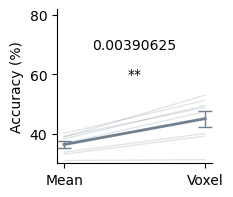

In [36]:
the_mean_am = np.zeros(np.size(list_acc_selected_mean,1))
the_mean_vr = np.zeros(np.size(max_data_2,1))
for i in range(np.size(max_data_2,1)):
    a = list_acc_selected_mean[:,i]
    the_mean_am[i] = np.nanmean(a[a!=0])
    b = max_data_2[:,i]
    the_mean_vr[i] = np.nanmean(b[b!=0])
the_mean_am = the_mean_am[:,np.newaxis]
the_mean_vr = the_mean_vr[:,np.newaxis]
data = np.concatenate((the_mean_am,the_mean_vr),axis = 1)
the_mean = np.mean(data,0)
the_std = np.std(data,0,ddof = 1)/math.sqrt(np.size(data,0))
plt.figure(figsize = (2,2))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.errorbar(range(2),the_mean,yerr=the_std,ecolor='slategray',elinewidth=1,marker='.',mfc='slategray',\
mec='slategray',mew=1,ms=1,alpha=1,capsize=5,capthick=3,color='slategray', linewidth=2)
for i in range(np.size(data,0)):
    plt.plot(data[i,:],color='slategray', linewidth=1,alpha = 0.2)
res = wilcoxon(data[:,0],data[:,1],alternative = 'less')
p = res.pvalue
if p<0.05 and p>=0.01:
    plt.text(0.5,60,'*',verticalalignment = 'center', horizontalalignment = 'center')
elif p<0.01 and p>0.001:
    plt.text(0.5,60,'**',verticalalignment = 'center', horizontalalignment = 'center')
elif p<0.001 and p>=0.0001:
    plt.text(0.5,60,'***',verticalalignment = 'center', horizontalalignment = 'center') 
elif p<0.0001:
    plt.text(0.5,60,'****',verticalalignment = 'center', horizontalalignment = 'center') 
plt.text(0.5,70,str(p),verticalalignment = 'center', horizontalalignment = 'center') 
plt.xticks([0,1],['Mean','Voxel'])
plt.ylim((30,82))
plt.ylabel(flag_name + ' (%)')
if if_save:
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.savefig(figure_save_path + '/' + 'am_vr_compare_C'+ str(channel_selected) +'.pdf',dpi = 300,bbox_inches = 'tight')
    plt.savefig(figure_save_path + '/' + 'am_vr_compare_C'+ str(channel_selected) + '.png',dpi = 300,bbox_inches = 'tight')
plt.show()